# Random Forest Example using atmospheric data from Christman Field

* Iris example adapted from: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* Further modified by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020
* Further adapted by: Prof. Elizabeth Barnes for ATS 780A7 Spring 2022 at Colorado State University

Lets import some libraries we will need throughout this tutorial:



In [1]:
# Pandas is used for data manipulation
import pandas as pd

# Use numpy to convert to arrays
import numpy as np

# Using Skicit-learn to split data into training and testing sets
import sklearn
from sklearn.model_selection import train_test_split

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Time formatter
import datetime

# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
import matplotlib.pyplot as plt
%matplotlib inline

# Permutation importance method from sklearn
from sklearn.inspection import permutation_importance


In [2]:
import print_environment
print_environment.colab_status()
print_environment.package_versions()

IN_COLAB = False
python version = 3.9.7 (default, Sep 16 2021, 08:50:36) 
[Clang 10.0.0 ]
numpy version = 1.21.5
scikit-learn version = 1.0.2


# 1. Data Preparation

### 1.1 Data overview

We have stored a .csv file on a CSU drive, accessible via URL. This will be the basis for our tutorial. This file contains Fort Collins weather data from 2018, and we will use these data to predict the high temperature for a given day with a random forest regression model.  

In [2]:
# Read in data from url
url = "http://schumacher.atmos.colostate.edu/hilla/temps_FC.csv"
features = pd.read_csv(url)

Lets look at our data to see what we are working with

In [3]:
# Display first 5 rows
print('The shape of our features is:', features.shape)
features.head(5)

The shape of our features is: (365, 11)


,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_BD,TMAX_SF,PRCP,TMAX_CLIM
0,2018,1,1,26,10,31,24,30,61,0.0,43.5
1,2018,1,2,41,5,26,31,46,61,0.0,43.6
2,2018,1,3,47,12,41,26,50,58,0.0,43.7
3,2018,1,4,51,18,47,41,52,63,0.0,43.8
4,2018,1,5,50,21,51,47,62,61,0.0,43.9


You will notice we have 365 days of features and labels (complete set from 2018). Our second features axis is the columns of the pandas dataframe. These columns represent the year, month, day, maximum temperature, minimum temperature, max temp from day before, max temp from two days prior, max temperature in Boulder, max temperature in San Francisco, precipitation, and climatological maximum. 

The max temperature column (TMAX) is actually our label: the observed max temperature at Fort Collins.

We can look quickly at some basic statistics of our data, such as mean, standard deviation, percentiles, etc. in a table format

In [4]:
# A handy tool in pandas: descriptive statistics for each column
features.describe()

,YEAR,MONTH,DAY,TMAX,TMIN,TMAX_1d,TMAX_2d,TMAX_BD,TMAX_SF,PRCP,TMAX_CLIM
count,365.0,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000
mean,2018.0,6.526027,15.720548,65.652055,37.389041,65.627397,65.564384,66.876712,63.904110,0.037260,63.738356
std,0.0,3.452584,8.808321,18.372280,16.232409,18.412798,18.515789,17.882819,6.004038,0.147239,15.407528
min,2018.0,1.000000,1.000000,15.000000,-3.000000,15.000000,15.000000,15.000000,51.000000,0.000000,42.100000
25%,2018.0,4.000000,8.000000,50.000000,24.000000,50.000000,50.000000,52.000000,60.000000,0.000000,48.100000
50%,2018.0,7.000000,16.000000,65.000000,37.000000,65.000000,65.000000,66.000000,63.000000,0.000000,63.000000
75%,2018.0,10.000000,23.000000,82.000000,52.000000,82.000000,82.000000,83.000000,67.000000,0.000000,78.500000
max,2018.0,12.000000,31.000000,101.000000,68.000000,101.000000,101.000000,98.000000,83.000000,1.740000,87.100000


We have made it so that there is not much to clean up in this dataset...however you may run into a scenario where days are missing, values are missing, etc. wherein you need to remove bad features, labels, or examples (i.e., days of observations). It is often said that 80% of machine learning is the preprocessing of your data. 


### 1.2 Targets and features

The pandas table is handy for a quick glance, but we need to organize some numpy arrays that separately contain our features and labels.

In [5]:
# Labels are the values we want to predict
labels = np.array(features['TMAX'])

# Remove the labels from the features
# axis 1 refers to the columns
features = features.drop('TMAX', axis = 1)

# Also remove TMAX_BD for later use, you will understand later
features = features.drop('TMAX_BD', axis = 1)

# TRY: Add in a random variable to train with some noise
#var_rand = np.round(np.random.rand(365)*365)
#features['rand'] = var_rand
#features.head(5)

# Saving feature names for later use
feature_list = list(features.columns)

# Convert to numpy array
features = np.array(features)

### 1.3 Splitting training and testing datasets

Assuming we have no feature data available from 2019 we could use to test our trained models against, we will want to split up our dataset into training and testing portions. A standard proportion is 3/4 for training, 1/4 for testing, although this is somewhat arbitrary here. 

In [6]:
# Split the data into training and testing sets

# Tunable Parameter: Describes the proportion of the dataset we want to use for testing. 1 - split_size is used for training. 
split_size = 0.25

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

Lets quickly check the size of our training and testing arrays are what we expect (and we didn't do something wrong)

In [7]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (273, 9)
Training Labels Shape: (273,)
Testing Features Shape: (92, 9)
Testing Labels Shape: (92,)


# 2. Playing with model

OK, our data is now split up into features and labels, as well as training and testing chunks. Now we will work to train and evaluate our model.

First, we need to know what our baseline skill is. Often, climatology is used and we will do just that, taking the climatological high temperature from the test features and evaluating it against the test labels

### 2.1 Establish Baseline

In [8]:
# You need a baseline to quantify whether the model is useful

# The baseline predictions here are the climatological values
# Grab all rows for the 'TMAX_CLIM' column
baseline_preds = test_features[:, feature_list.index('TMAX_CLIM')]

# Baseline errors (mean absolute errors)
mae_baseline_errors = abs(baseline_preds - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))

# Baseline errors (mean squared errors)
mse_baseline_errors = np.sqrt(np.mean((baseline_preds - test_labels)**2))
print('Baseline error (MSE): ', round(mse_baseline_errors, 2))

Baseline error (MAE):  7.56
Baseline error (MSE):  9.3


Subjectively, these errors seem quite high, but as one might expect when trying to predict high temperatures from climatology. I think we can improve upon this with a RF model

### 2.2 Train model

As mentioned in the slides, there are a number of hyperparameters for RF models that we can tweak and tune to make the model perform better. We will start with a base set of hyperparameters that are defaults for the RF regression model in scikit-learn. 

In [9]:
# Tunable Parameters for Model
number_of_trees = 10
tree_depth = None 
node_split = 2       # minimum number of training samples needed to split a node
leaf_samples = 1     # minimum number of training samples required to make a leaf node
criterion = 'mse'    # variance reduction, alternatively 'mae'
RAND_STATE = 42

# Instantiate model with number of decision trees prescribed above
# PARAMETERS:
#     n_estimators: number of trees/ensembles
#     random_state: random seed
#     max_depth: maximum depth of each tree
#     criterion: evaluation statistic to split a mode, 'mse'  or 'mae'
#     min_samples_split: minimum number of samples needed to split a node
#     min_samples_leaf: minimum number of samples needed to make a leaf
#     for more, see: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
rf = RandomForestRegressor(n_estimators = number_of_trees, 
                           random_state = RAND_STATE,
                           min_samples_split = node_split,
                           min_samples_leaf = leaf_samples,
                           criterion = criterion,
                           max_depth = tree_depth)

# Train the model on training data
rf.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=10, random_state=42)

Just a handful of lines of code to train the model. Easy peasy. Now lets make some predictions from our model

### 2.3 Make predictions

In [10]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)

# Use testing set to validate the performance
# Print out the mean absolute error (MAE)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))

# See its performance (mean squared errors)
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  6.31
Baseline error (MSE):  9.3
Error (MSE):  7.72


Not too shabby, we have improved our forecast skill by about 1.5 degrees by using an RF. 

Question: Does the size of our training/testing samples matter? 

In [11]:
def split_size_impact(sizes=[0.25,0.5]):

    for size in sizes:

        split_size = size
        train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = RAND_STATE)
        number_of_trees = 10
        tree_depth = None 
        node_split = 2       # minimum number of training samples needed to split a node
        leaf_samples = 1     # minimum number of training samples required to make a leaf node
        criterion = 'mse'    # variance reduction, alternatively 'mae'
        rf = RandomForestRegressor(n_estimators = number_of_trees, 
                               random_state = RAND_STATE,
                               min_samples_split = node_split,
                               min_samples_leaf = leaf_samples,
                               criterion = criterion,
                               max_depth = tree_depth)
        rf.fit(train_features, train_labels);

        predictions = rf.predict(test_features)

        print('Split size: ',size)
        mae_errors = abs(predictions - test_labels)
        print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
        print('Error (MAE): ', round(np.mean(mae_errors), 2))

        mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
        print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
        print('Error (MSE): ', round(mse_errors, 2))
        print('')

Compute error stats for a range of training/testing samples sizes

In [12]:
split_size_impact(sizes=np.arange(0.1,0.8,0.05))

Split size:  0.1
Baseline error (MAE):  7.56
Error (MAE):  6.06
Baseline error (MSE):  9.3
Error (MSE):  8.05

Split size:  0.15000000000000002
Baseline error (MAE):  7.56
Error (MAE):  6.17
Baseline error (MSE):  9.3
Error (MSE):  8.03

Split size:  0.20000000000000004
Baseline error (MAE):  7.56
Error (MAE):  5.53
Baseline error (MSE):  9.3
Error (MSE):  7.46

Split size:  0.25000000000000006
Baseline error (MAE):  7.56
Error (MAE):  6.31
Baseline error (MSE):  9.3
Error (MSE):  7.72

Split size:  0.30000000000000004
Baseline error (MAE):  7.56
Error (MAE):  6.46
Baseline error (MSE):  9.3
Error (MSE):  8.09

Split size:  0.3500000000000001
Baseline error (MAE):  7.56
Error (MAE):  6.01
Baseline error (MSE):  9.3
Error (MSE):  7.67

Split size:  0.40000000000000013
Baseline error (MAE):  7.56
Error (MAE):  6.19
Baseline error (MSE):  9.3
Error (MSE):  7.78

Split size:  0.45000000000000007
Baseline error (MAE):  7.56
Error (MAE):  5.95
Baseline error (MSE):  9.3
Error (MSE):  7.35

S

It looks like, generally, skill only varies by about half a degree from worst and best RF models. Subjectively, not a lot of sensitivity. 

### 2.4 Model Optimization

Now that we have marginally improved our skill, we can try and optimize our forecasts as well. 

Tunable parameters: \\
-Number of trees \\
-Tree Depth \\
-Minimum number of samples to split a node \\
-Minimum number of samples to get a leaf \\
-Splitting criterion (in this case it is MSE or MAE) \\
-Testing/training lengths \\

Lets look at some trained models with different parameters and see if we can find an improved RF

First, we will increase our number of trees. Other variables should be the same


In [13]:
# Started with 10
number_of_trees = 70
tree_depth = None

rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  5.83
Baseline error (MSE):  9.3
Error (MSE):  7.26


Using increments of 10, we see that MSE is optimal at about 60 or 70 trees. *Now* lets try tree depth...

In [14]:
#Default was None
tree_depth = 14
number_of_trees = 70

rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  5.82
Baseline error (MSE):  9.3
Error (MSE):  7.24


Skill maximized at a tree depth of 5...but skill was still pretty good at a depth of 14 too. Little sensitivity to depth when number of trees is at 70. 
Criterion?

In [15]:
# Default 'mse'
criterion = 'mse'
number_of_trees = 70
tree_depth = 14

rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  5.82
Baseline error (MSE):  9.3
Error (MSE):  7.24


Also little sensitivity. Now lets change the minimum number of samples to split a node...

In [16]:
# Default = 2
node_split = 14
number_of_trees = 70
tree_depth = 14
criterion = 'mse'

rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  5.71
Baseline error (MSE):  9.3
Error (MSE):  7.17


Local minimum maybe around 14 samples. Finally, lets see if the number of samples in a leaf matters...

In [17]:
# Default = 1
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 14
criterion = 'mse'

rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
rf.fit(train_features, train_labels);
predictions = rf.predict(test_features)
mae_errors = abs(predictions - test_labels)
print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
print('Error (MAE): ', round(np.mean(mae_errors), 2))
mse_errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(mse_errors, 2))

Baseline error (MAE):  7.56
Error (MAE):  5.64
Baseline error (MSE):  9.3
Error (MSE):  7.04


While I have no clue if this is globally optimized, as we only went through a few permutations while keeping other variables constant, you can get an idea for the strategies to take when trying to optimize your model. In this case, we found the default RF values didn't provide the most optimal model. We were able to increase our predictive skill by about 3/4 of a degree. 

One thing we have yet to discuss is the selection of our training and testing datasets. In some applications, it might be more appropriate to select your datasets as contiguous chunks, rather than random subsets. Can anything think of why this would be the case???

### 2.5 Training Segments and Length

Lets take the same approach as before, with a segment legnth of 1/4 for testing, but instead of randomly sampling, lets take a contiguous chunk. We will try a couple different chunks too (i.e., cross validate) 

In [18]:
# Split the data into training and testing sets
split_size = 0.1      # chunk size for testing
train_length = 0.9    # chunk size for training
num_cv = 10             # number of cross-validation tests

cv_train_features = []
cv_train_labels = []
cv_test_features = []
cv_test_labels = []

for i in range(0,num_cv):
  if i == (num_cv - 1):  # last chunk is for testing
    cv_train_features.append(features[:round(len(features[:,0]) * train_length)])
    cv_train_labels.append(labels[:round(len(features[:,0]) * train_length)])

    cv_test_features.append(features[round(len(features[:,0]) * train_length):])
    cv_test_labels.append(labels[round(len(features[:,0]) * train_length):])
  elif i == 0:          # first chunk is for testing
    cv_train_features.append(features[round(len(features[:,0])*split_size):])
    cv_train_labels.append(labels[round(len(features[:,0])*split_size):])

    cv_test_features.append(features[:round(len(features[:,0])*split_size)])
    cv_test_labels.append(labels[:round(len(features[:,0])*split_size)])
  else:                 # chunk is in the middle of training dataset
    chunk_size = round(len(features[:,0]) * split_size)
    first_chunk = features[:(i*chunk_size)]
    second_chunk = features[((i+1)*chunk_size):]

    cv_train_features.append(np.concatenate((first_chunk, second_chunk),axis=0))
    cv_train_labels.append(np.append(labels[:(i * chunk_size)], labels[(i + 1) * chunk_size:]))

    cv_test_features.append(features[(i * chunk_size):(i + 1) * chunk_size])
    cv_test_labels.append(labels[(i * chunk_size):(i + 1) * chunk_size])

  print('Chunk :',(i+1))
  print('Training Features Shape:', cv_train_features[i].shape)
  print('Training Labels Shape:', cv_train_labels[i].shape)
  print('Testing Features Shape:', cv_test_features[i].shape)
  print('Testing Labels Shape:', cv_test_labels[i].shape)

Chunk : 1
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 2
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 3
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 4
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 5
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 6
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 7
Training Features Shape: (329, 9)
Training Labels Shape: (329,)
Testing Features Shape: (36, 9)
Testing Labels Shape: (36,)
Chunk : 8
Training Features Shape: (329, 9)
Training Labels Sh

Alright, great. Each of our training sets is of equal length, as is the testing sets. Now lets make RF models for each of these using the "optimized" config found before. 

In [19]:
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 5
criterion = 'mse'

cv_predictions = []
for i in range(0,num_cv):
  cv_rf = RandomForestRegressor(n_estimators = number_of_trees, random_state = 42,min_samples_split = node_split,min_samples_leaf = leaf_samples,criterion = criterion,max_depth = tree_depth)
  cv_rf.fit(cv_train_features[i], cv_train_labels[i]);
  i_predictions = cv_rf.predict(cv_test_features[i])
  cv_predictions.append(i_predictions)
  mae_errors = abs(i_predictions - cv_test_labels[i])
  print('Model :',(i+1))
  print('Baseline error (MAE): ', round(np.mean(mae_baseline_errors), 2))
  print('Error (MAE): ', round(np.mean(mae_errors), 2))
  mse_errors = np.sqrt(np.mean((i_predictions - cv_test_labels[i])**2))
  print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
  print('Error (MSE): ', round(mse_errors, 2))
  print('')

Model : 1
Baseline error (MAE):  7.56
Error (MAE):  7.25
Baseline error (MSE):  9.3
Error (MSE):  8.76

Model : 2
Baseline error (MAE):  7.56
Error (MAE):  8.14
Baseline error (MSE):  9.3
Error (MSE):  10.53

Model : 3
Baseline error (MAE):  7.56
Error (MAE):  6.01
Baseline error (MSE):  9.3
Error (MSE):  7.11

Model : 4
Baseline error (MAE):  7.56
Error (MAE):  6.52
Baseline error (MSE):  9.3
Error (MSE):  7.86

Model : 5
Baseline error (MAE):  7.56
Error (MAE):  4.87
Baseline error (MSE):  9.3
Error (MSE):  6.0

Model : 6
Baseline error (MAE):  7.56
Error (MAE):  4.18
Baseline error (MSE):  9.3
Error (MSE):  5.69

Model : 7
Baseline error (MAE):  7.56
Error (MAE):  4.68
Baseline error (MSE):  9.3
Error (MSE):  6.1

Model : 8
Baseline error (MAE):  7.56
Error (MAE):  6.99
Baseline error (MSE):  9.3
Error (MSE):  8.89

Model : 9
Baseline error (MAE):  7.56
Error (MAE):  6.79
Baseline error (MSE):  9.3
Error (MSE):  7.91

Model : 10
Baseline error (MAE):  7.56
Error (MAE):  7.03
Baselin

Interestingly, one of our contiguously-trained models outperforms the randomly-sampled model. Lets take a look at what our models are predicting visually with graphs in a time series

### 2.6 Visualization of prediction

#### Randomly-sampled trained model

In [20]:
def plot_time_series(features, feature_list, labels, test_features, predictions):
  # Use datetime for creating date objects for plotting
  # Dates of training values
  months = features[:, feature_list.index('MONTH')]
  days = features[:, feature_list.index('DAY')]
  years = features[:, feature_list.index('YEAR')]
  # List and then convert to datetime object
  dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
  dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
  # Dataframe with true values and dates
  true_data = pd.DataFrame(data = {'date': dates, 'TMAX': labels})
  # Dates of predictions
  months = test_features[:, feature_list.index('MONTH')]
  days = test_features[:, feature_list.index('DAY')]
  years = test_features[:, feature_list.index('YEAR')]
  # Column of dates
  test_dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
  # Convert to datetime objects
  test_dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in test_dates]
  # Dataframe with predictions and dates
  predictions_data = pd.DataFrame(data = {'date': test_dates, 'prediction': predictions})
  # Plot the actual values
  plt.plot(true_data['date'], true_data['TMAX'], 'b-', label = 'TMAX')
  # Plot the predicted values
  plt.plot(predictions_data['date'], predictions_data['prediction'], 'ro', label = 'prediction')
  plt.xticks(rotation = '60'); 
  plt.legend()
  # Graph labels
  plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual and Predicted Values');
  plt.show()

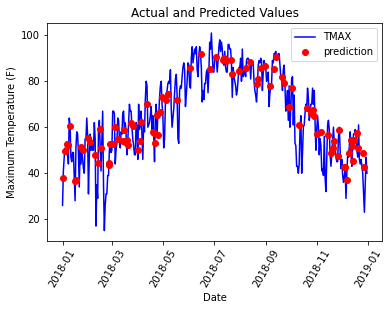

In [21]:
# Use datetime for creating date objects for plotting
# Dates of training values
plot_time_series(features, feature_list, labels, test_features, predictions)

#### Contiguous Chunk Trained Models

Model:  1


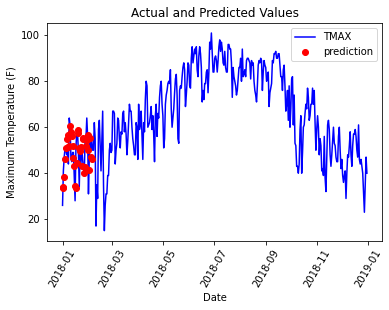

Model:  2


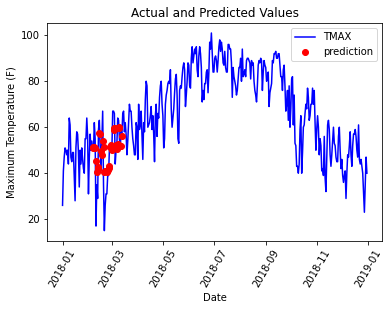

Model:  3


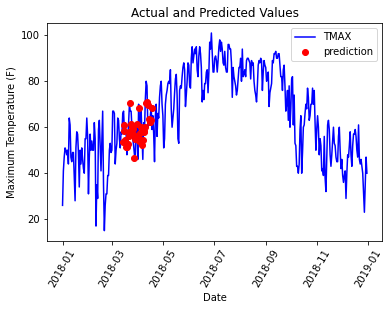

Model:  4


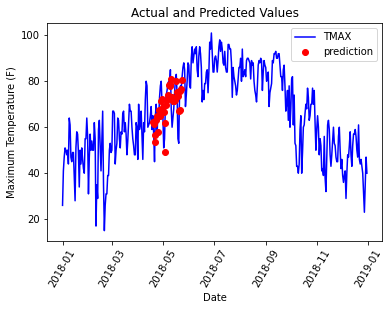

Model:  5


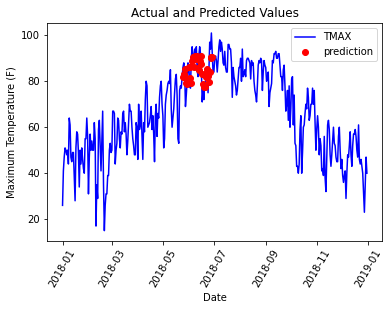

Model:  6


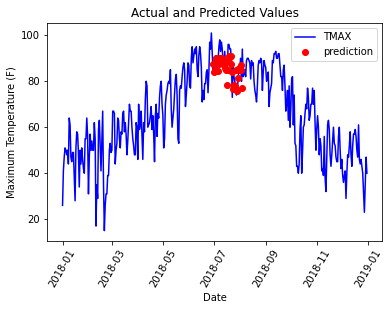

Model:  7


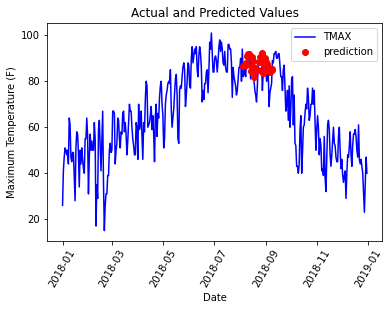

Model:  8


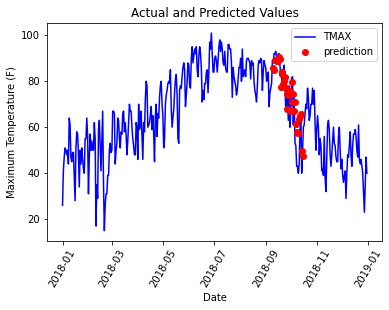

Model:  9


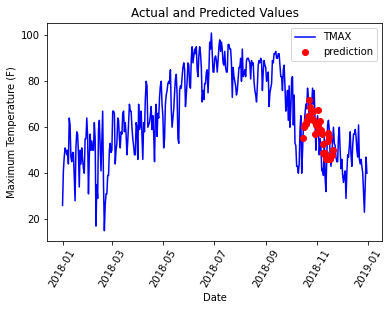

Model:  10


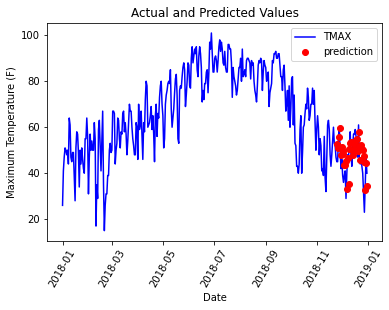

In [22]:
for i in range(0, num_cv):
  print('Model: ',(i+1))
  plot_time_series(features, feature_list, labels, cv_test_features[i], cv_predictions[i])

There may be advantages to organizing your training/testing in this manner, particularly when dealing with examples that are entirely independent from one another, e.g., daily weather patterns.  

# VISUALIZATION TECHNIQUES

### 3.1 Visualizing a Single Decision Tree

In [23]:
# 1. Make the path of your own Google Drive accessible
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# Require folks to download the whole folder (ML tutorial) before showing up
# local_path = '/content/drive/My Drive'
local_path = 'figures/'

In [24]:
# Pull out one tree from the forest
tree = rf.estimators_[40]

# Export the image to a dot file
export_graphviz(tree, out_file = '{}/tree.dot'.format(local_path), feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('{}/tree.dot'.format(local_path))

# Write graph to a png file
png_name = 'tree.png'
graph.write_png('{}/{}'.format(local_path, png_name))
# see it in your Google Drive!


### 3.2 Feature Importances

First we will look at Impurity Importance, which is built into Scikit-learn. 

In [25]:
def calc_importances(rf, feature_list):

  # Get numerical feature importances
  importances = list(rf.feature_importances_)

  # List of tuples with variable and importance
  feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]

  # Sort the feature importances by most important first
  feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

  # Print out the feature and importances 
  [print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

  return importances

In [26]:
def plot_feat_importances(importances, feature_list): 
  plt.figure()
  # Set the style
  plt.style.use('fivethirtyeight')
  # list of x locations for plotting
  x_values = list(range(len(importances)))
  # Make a bar chart
  plt.barh(x_values, importances)
  # Tick labels for x axis
  plt.yticks(x_values, feature_list)
  # Axis labels and title
  plt.xlabel('Importance'); plt.ylabel('Variable'); plt.title('Variable Importances');

Variable: TMAX_CLIM            Importance: 0.41
Variable: TMAX_1d              Importance: 0.35
Variable: TMIN                 Importance: 0.17
Variable: PRCP                 Importance: 0.04
Variable: DAY                  Importance: 0.01
Variable: TMAX_2d              Importance: 0.01
Variable: TMAX_SF              Importance: 0.01
Variable: YEAR                 Importance: 0.0
Variable: MONTH                Importance: 0.0


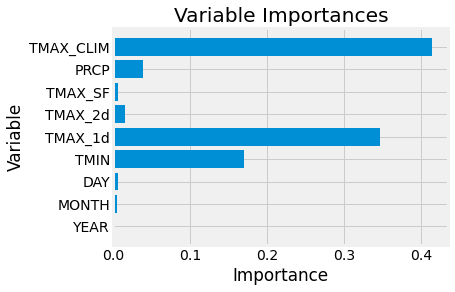

In [27]:
plot_feat_importances(calc_importances(rf, feature_list), feature_list)

### 3.3 Permutation Importances

In [28]:
# Single-pass permutation
permute = permutation_importance(rf, test_features, test_labels, n_repeats=10, 
                                 random_state=42)

# Sort the importances
sorted_idx = permute.importances_mean.argsort()

First, lets look at what is most important in the test set

In [29]:
def plot_perm_importances(permute, sorted_idx, feature_list):
  # Sort the feature list based on 

  new_feature_list = []
  for index in sorted_idx:  
    new_feature_list.append(feature_list[index])

  fig, ax = plt.subplots()
  ax.boxplot(permute.importances[sorted_idx].T,
           vert=False, labels=new_feature_list)
  ax.set_title("Permutation Importances")
  fig.tight_layout()

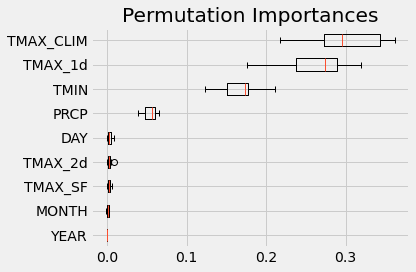

In [30]:
plot_perm_importances(permute, sorted_idx, feature_list)

How about in the training set?

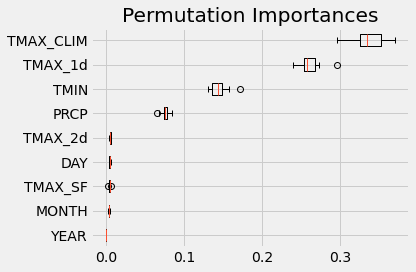

In [31]:
permute = permutation_importance(rf, train_features, train_labels, n_repeats=10, random_state=42)
sorted_idx = permute.importances_mean.argsort()

plot_perm_importances(permute, sorted_idx, feature_list)

### 3.4 Comparing Predictors

It may be beneficial at times to compare your labels to predictors, which can something explain why certain features are better than others. Lets plot the time series for max temp and a couple features

In [32]:
def plot_features(features, variables=['TMAX','TMAX_1d','TMAX_CLIM','TMIN']):
  # Make the data accessible for plotting
  # Dates of training values
  months = features[:, feature_list.index('MONTH')]
  days = features[:, feature_list.index('DAY')]
  years = features[:, feature_list.index('YEAR')]
  # List and then convert to datetime object
  dates = [str(int(year)) + '-' + str(int(month)) + '-' + str(int(day)) for year, month, day in zip(years, months, days)]
  dates = [datetime.datetime.strptime(date, '%Y-%m-%d') for date in dates]
  # Make the data accessible for plotting
  true_data = pd.DataFrame(data = {'date': dates, 'TMAX': labels})
  true_data[variables[1]] = features[:, feature_list.index(variables[1])]
  true_data[variables[2]] = features[:, feature_list.index(variables[2])]
  true_data[variables[3]] = features[:, feature_list.index(variables[3])]
  # Plot all the data as lines
  plt.plot(true_data['date'], true_data['TMAX'], 'b-', label  = 'TMAX', alpha = 1.0)
  plt.plot(true_data['date'], true_data[variables[1]], 'y-', label  = variables[1], alpha = 1.0)
  plt.plot(true_data['date'], true_data[variables[2]], 'k-', label = variables[2], alpha = 0.8)
  plt.plot(true_data['date'], true_data[variables[3]], 'r-', label = variables[3], alpha = 0.3)
  # Formatting plot
  plt.legend(); plt.xticks(rotation = '60');
  # Lables and title
  plt.xlabel('Date'); plt.ylabel('Maximum Temperature (F)'); plt.title('Actual Max Temp and Variables');

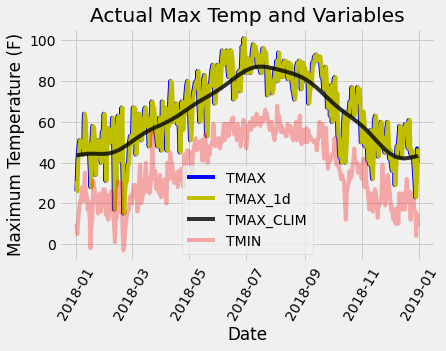

In [33]:
plot_features(features)

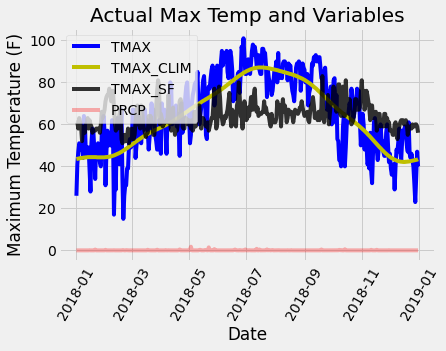

In [34]:
plot_features(features, variables=['TMAX','TMAX_CLIM','TMAX_SF','PRCP'])

### Extra: Train a Model Using Only a Subset of Predictors

In [35]:
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 5
criterion = 'mse'

#Reload in features to clean things up a bit 
features = pd.read_csv(url)
features = features.drop('TMAX', axis = 1)
features = features.drop('TMAX_BD', axis = 1)

feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators = number_of_trees, 
                                          random_state = 42,
                                          min_samples_split = node_split,
                                          min_samples_leaf = leaf_samples,
                                          criterion = criterion,
                                          max_depth = tree_depth)

# Use the top 4 predictors, as determined by feature importance
important_indices = [feature_list.index('PRCP'), feature_list.index('TMAX_CLIM'), feature_list.index('TMAX_1d'), feature_list.index('TMIN')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(errors, 2))

Baseline error (MSE):  9.3
Error (MSE):  7.6


In [36]:
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 5
criterion = 'mse'

#Reload in features to clean things up a bit 
features = pd.read_csv(url)
features = features.drop('TMAX', axis = 1)
features = features.drop('TMAX_BD', axis = 1)

feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators = number_of_trees, 
                                          random_state = 42,
                                          min_samples_split = node_split,
                                          min_samples_leaf = leaf_samples,
                                          criterion = criterion,
                                          max_depth = tree_depth)

# Use the top 4 predictors, as determined by permutation importance
important_indices = [feature_list.index('PRCP'), feature_list.index('TMAX_CLIM'), feature_list.index('TMAX_SF'), feature_list.index('TMAX_2d')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(errors, 2))

Baseline error (MSE):  9.3
Error (MSE):  9.54


## Extra: Woah Nelly Results

Remember at the very beginning of the tutorial when we withheld Boulder's high temperature? Well lets add that back in and train a model. 

In [37]:
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 5
criterion = 'mse'

#Reload in features and don't delete Boulder data
features = pd.read_csv(url)
features = features.drop('TMAX', axis = 1)

# Save this for a little bit...
#features = features.drop('TMAX_CLIM', axis = 1)
#features = features.drop('PRCP', axis = 1)
#features = features.drop('TMAX_SF', axis = 1)
#features = features.drop('TMAX_BD', axis = 1)

feature_list = list(features.columns)
features = np.array(features)
train_important, test_important, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators = number_of_trees, 
                                          random_state = 42,
                                          min_samples_split = node_split,
                                          min_samples_leaf = leaf_samples,
                                          criterion = criterion,
                                          max_depth = tree_depth)

# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(errors, 2))

Baseline error (MSE):  9.3
Error (MSE):  3.64


Error is SIGNIFICANTLY reduced. 

Lets look at predictor importance real quick...



In [38]:
new_importances = list(rf_most_important.feature_importances_)
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, new_importances)]
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)



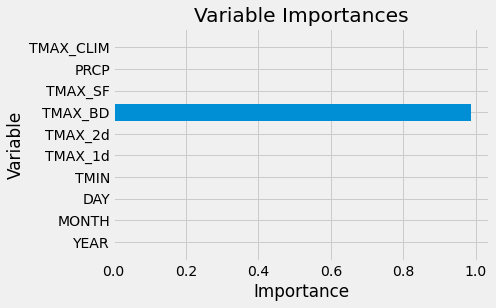

In [39]:
plot_feat_importances(new_importances, feature_list)

In [40]:
# Pull out one tree from the forest
tree = rf_most_important.estimators_[40]

# Export the image to a dot file
export_graphviz(tree, out_file = '{}/tree.dot'.format(local_path), feature_names = feature_list, rounded = True, precision = 1)

# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('{}/tree.dot'.format(local_path))

# Write graph to a png file
png_name = 'tree.png'
graph.write_png('{}/{}'.format(local_path, png_name))
# see it in your Google Drive!

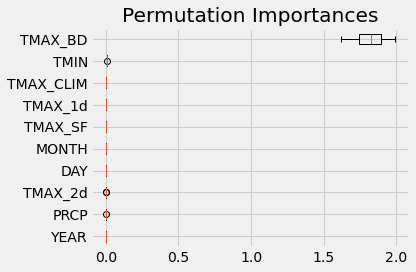

In [41]:
permute = permutation_importance(rf_most_important, train_important, train_labels, n_repeats=10 )
sorted_idx = permute.importances_mean.argsort()
plot_perm_importances(permute, sorted_idx, feature_list)

Impurity feature importance suggests that the Boulder observation is extremely important, while the permutation importance thinks the climatology is most important. But if we look at a tree, we can see that the Boulder observation is littered across the top of trees; of course the impurity importance will pick it out!

What if we trained the model JUST using Boulders high temperature???

In [42]:
leaf_samples = 5
node_split = 14
number_of_trees = 70
tree_depth = 5
criterion = 'mse'

#Reload in features to clean things up a bit 
features = pd.read_csv(url)
features = features.drop('TMAX', axis = 1)

feature_list = list(features.columns)
features = np.array(features)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = split_size, random_state = 42)

# New random forest with only the two most important variables
rf_most_important = RandomForestRegressor(n_estimators = number_of_trees, 
                                          random_state = 42,
                                          min_samples_split = node_split,
                                          min_samples_leaf = leaf_samples,
                                          criterion = criterion,
                                          max_depth = tree_depth)

# Use the top 4 predictors, as determined by permutation importance
important_indices = [feature_list.index('TMAX_BD')]
train_important = train_features[:, important_indices]
test_important = test_features[:, important_indices]
# Train the random forest
rf_most_important.fit(train_important, train_labels)
# Make predictions
predictions = rf_most_important.predict(test_important)
# Display the performance metrics
errors = np.sqrt(np.mean((predictions - test_labels)**2))
print('Baseline error (MSE): ', round( mse_baseline_errors, 2))
print('Error (MSE): ', round(errors, 2))

Baseline error (MSE):  9.3
Error (MSE):  3.78
